In [126]:
import pandas as pd
import numpy as np
np.set_printoptions(threshold=np.inf)

In [127]:
data = np.load('data.npy', allow_pickle=True)

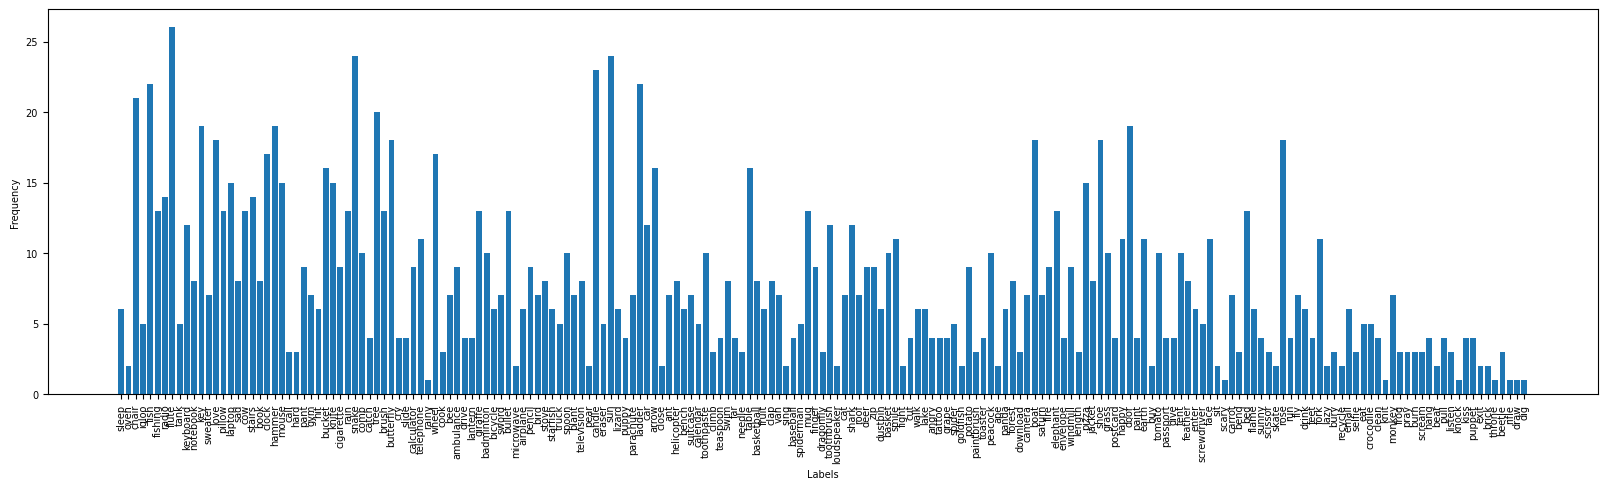

In [179]:
import matplotlib.pyplot as plt

labels = data[:, 3]
freq = {}
for i in labels:
    if i in freq:
        freq[i] += 1
    else:
        freq[i] = 1

plt.rcParams.update({'font.size': 7})
plt.figure(figsize=(20, 5))
plt.bar(range(len(freq)), list(freq.values()), tick_label=list(freq.keys()))
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.xlabel("Labels")
plt.show()

In [130]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from time import time


class KNN:
    def __init__(self, k, distance_measure, encoder_type):
        self.k = k
        self.distance_measure = distance_measure
        if (encoder_type == "ResNet"):
            self.encoder_type = 1
        if (encoder_type == "VIT"):
            self.encoder_type = 2

    def set_hyperparameters(self, k, distance_measure, encoder_type):
        self.k = k
        self.distance_measure = distance_measure
        if (encoder_type == "ResNet"):
            self.encoder_type = 1
        if (encoder_type == "VIT"):
            self.encoder_type = 2

    def euclidean_distance(self, point1, point2):
        return np.sqrt(np.sum((point1 - point2)**2))

    def manhattan_distance(self, point1, point2):
        return np.sum(np.abs(point1 - point2))

    def cosine_distance(self, vector1, vector2):
        dot_product = np.dot(vector1, vector2.T)
        magnitude_product = np.linalg.norm(vector1) * np.linalg.norm(vector2)
        return 1 - dot_product / magnitude_product

    def classify(self, x_train, x_test, y_train, y_test):
        start = time()
        x_train = x_train[:, self.encoder_type]
        x_test = x_test[:, self.encoder_type]
        predicted = []
        for x in x_test:
            dist = []
            sz = len(x_train)
            for i in range(sz):
                if (self.distance_measure == "euclidean"):
                    d = self.euclidean_distance(x, x_train[i])
                    dist.append([d, y_train[i]])
                if (self.distance_measure == "manhattan"):
                    d = self.manhattan_distance(x, x_train[i])
                    dist.append([d, y_train[i]])
                if (self.distance_measure == "cosine"):
                    d = self.cosine_distance(x, x_train[i])
                    dist.append([d, y_train[i]])
            dist.sort()
            freq = {}
            for i in range(self.k):
                label = dist[i][1]
                if (label in freq):
                    freq[label] += 1
                else:
                    freq[label] = 1
            curr = 0
            predicted_label = ""
            for label in freq:
                if (freq[label] > curr):
                    curr = freq[label]
                    predicted_label = label
            predicted.append(predicted_label)
        end = time()
        accuracy = accuracy_score(y_test, predicted)
        precision = precision_score(
            y_test, predicted, average="weighted", zero_division=0)
        recall = recall_score(
            y_test, predicted, average="weighted", zero_division=0)
        f1 = f1_score(y_test, predicted, average="weighted", zero_division=0)
        inference_time = end-start
        return accuracy, precision, recall, f1, inference_time

In [138]:
x = data
y = data[:, 3]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

knn = KNN(5, "euclidean", "ResNet")
performance_measures = knn.classify(x_train, x_test, y_train, y_test)
print("Accuracy :", performance_measures[0])
print("Precision :", performance_measures[1])
print("Recall :", performance_measures[2])
print("F1 Score :", performance_measures[3])
print("Inference Time :", performance_measures[4])

Accuracy : 0.19333333333333333
Precision : 0.19727011877011877
Recall : 0.19333333333333333
F1 Score : 0.17629608354608353
Inference Time : 2.404005527496338


In [149]:
n = int(len(x_train)**(0.5))

encoder_type = ["ResNet", "VIT"]
distance_measure = ["euclidean", "manhattan", "cosine"]

x = data
y = data[:, 3]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

rank = {}
inference_time = {}
for k in range(1, n, 2):
    for encoder in encoder_type:
        for distance in distance_measure:
            knn.set_hyperparameters(k, distance, encoder)
            performance_measures = knn.classify(
                x_train, x_test, y_train, y_test)
            accuracy = performance_measures[0]
            rank[(k, encoder, distance)] = accuracy
            inference_time[(k, encoder, distance)] = performance_measures[4]

In [150]:
rank = dict(sorted(rank.items(), key=lambda x: x[1], reverse=True))
# for k in rank:
#     print(k, rank[k])

In [159]:
best_knn = (list(rank.keys()))[0]
print("Best knn triplet :", best_knn)

Best knn triplet : (5, 'VIT', 'euclidean')


In [158]:
print("Top 20 triplets :")
print()
i = 0
for k in rank:
    print(k)
    i += 1
    if (i == 20):
        break

Top 20 triplets :

(5, 'VIT', 'euclidean')
(5, 'VIT', 'manhattan')
(3, 'VIT', 'manhattan')
(5, 'VIT', 'cosine')
(7, 'VIT', 'manhattan')
(7, 'VIT', 'euclidean')
(3, 'VIT', 'cosine')
(15, 'VIT', 'manhattan')
(3, 'VIT', 'euclidean')
(7, 'VIT', 'cosine')
(1, 'VIT', 'euclidean')
(1, 'VIT', 'manhattan')
(1, 'VIT', 'cosine')
(9, 'VIT', 'euclidean')
(9, 'VIT', 'manhattan')
(13, 'VIT', 'euclidean')
(27, 'VIT', 'manhattan')
(29, 'VIT', 'manhattan')
(9, 'VIT', 'cosine')
(33, 'VIT', 'manhattan')


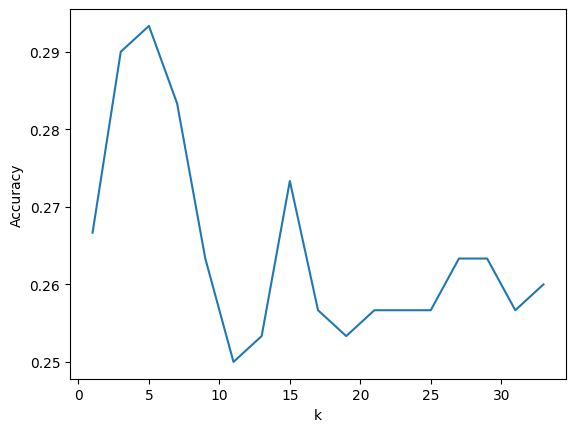

In [160]:
encoder = "VIT"
distance = "manhattan"
x = []
y = []
for k in range(1, n, 2):
    x.append(k)
    y.append(rank[(k, encoder, distance)])
    # print((k,encoder,distance),rank[(k,encoder,distance)])
x = np.array(x)
y = np.array(y)
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.plot(x, y)
plt.show()

In [164]:
from sklearn.neighbors import KNeighborsClassifier

# Default knn

data = np.load('data.npy', allow_pickle=True)
# taking VIT dataset and k=7 for default
x_default = data[:, 1]
y_default = data[:, 3]
x_train_default, x_test_default, y_train_default, y_test_default = train_test_split(
    x_default, y_default, test_size=0.2)
k = 7
knn_default = KNeighborsClassifier(n_neighbors=k)
x_train_default_ = []
for i in x_train_default:
    x_train_default_.append(i[0])
knn_default.fit(x_train_default_, y_train_default)
x_test_default_ = []
for i in x_test_default:
    x_test_default_.append(i[0])
start = time()
y_pred = knn_default.predict(x_test_default_)
end = time()
inference_time_default = end-start
accuracy = accuracy_score(y_test_default, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.18333333333333332


In [143]:
inference_time = dict(sorted(inference_time.items(), key=lambda x: x[1]))
# for i in inference_time:
#     print(i, inference_time[i])

In [144]:
optimized_knn = (list(inference_time.keys()))[0]
print(optimized_knn)

(25, 'VIT', 'manhattan')


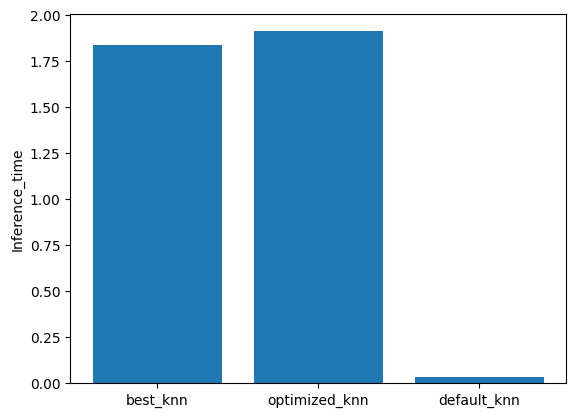

In [165]:
# print(inference_time[best_knn])
# print(inference_time[optimized_knn])
# print(inference_time_default)

x = ["best_knn", "optimized_knn", "default_knn"]
y = [inference_time[best_knn], inference_time[optimized_knn], inference_time_default]
plt.bar(x, y)
plt.ylabel("Inference_time")
plt.show()

In [132]:

training_size = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

default_knn_inference_time = []
best_knn_inference_time = []
optimized_knn_inference_time = []

for i in training_size:
    x = data
    y = data[:, 3]
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=1-i)
    rank = {}
    inference_time = {}
    for k in range(1, n, 2):
        for encoder in encoder_type:
            for distance in distance_measure:
                knn.set_hyperparameters(k, distance, encoder)
                performance_measures = knn.classify(
                    x_train, x_test, y_train, y_test)
                accuracy = performance_measures[0]
                rank[(k, encoder, distance)] = accuracy
                inference_time[(k, encoder, distance)
                               ] = performance_measures[4]
    rank = dict(sorted(rank.items(), key=lambda x: x[1], reverse=True))
    best_knn = (list(rank.keys()))[0]
    inference_time = dict(sorted(inference_time.items(), key=lambda x: x[1]))
    optimized_knn = (list(inference_time.keys()))[0]

    # Default knn
    # taking VIT dataset and k=7 for default
    x_default = data[:, 1]
    y_default = data[:, 3]
    x_train_default, x_test_default, y_train_default, y_test_default = train_test_split(
        x_default, y_default, test_size=1-i)
    k = 7
    neigh = KNeighborsClassifier(n_neighbors=k)
    x_train_default_ = []
    for i in x_train_default:
        x_train_default_.append(i[0])
    neigh.fit(x_train_default_, y_train_default)
    x_test_default_ = []
    for i in x_test_default:
        x_test_default_.append(i[0])
    start = time()
    y_pred = neigh.predict(x_test_default_)
    end = time()
    default_knn_inference_time.append(end-start)

    # Best knn
    best_knn_inference_time.append(inference_time[best_knn])

    # Optimized knn
    optimized_knn_inference_time.append(inference_time[optimized_knn])

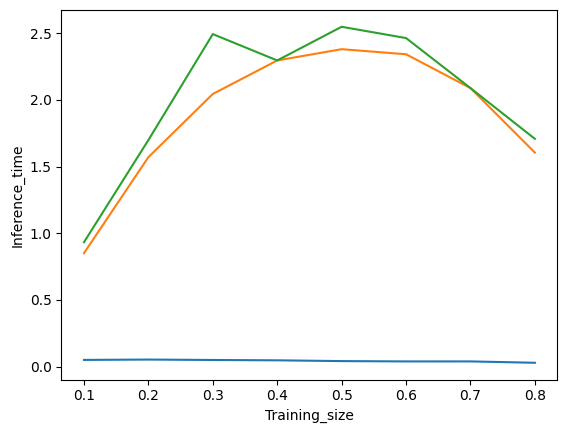

In [161]:
# print(best_knn_inference_time)
# print(optimized_knn_inference_time)

plt.plot(training_size, default_knn_inference_time)
plt.plot(training_size, optimized_knn_inference_time)
plt.plot(training_size, best_knn_inference_time)
plt.xlabel("Training_size")
plt.ylabel("Inference_time")
plt.show()